## Introduction



Memory judgments in item recognition tests can be influenced by familiarity-based processes like processing fluency. While traditional accounts of source memory suggest minimal impact of familiarity, recent work indicates that source memory judgments can be affected when test stimuli are processed with greater fluency due to priming. The experiments in this paper investigated the relationship between fluency and the accuracy of source memory decisions.   

This analysis reproduces the findings from Experiment 1 of Huang and Shanks (2021), which aimed to investigate how fluency relates to source memory responses, including the more commonly used R/K or R/K/G responses. Another goal was to address the lack of research on memory involving multiple source attributes crossed at encoding and jointly retrieved. Participants studied words presented with different source attributes (font size and location). During testing, they identified words that clarified on screen through progressive demasking (CID-R task), made old/new and source memory judgments, and provided confidence ratings. Identification response times (RTs) from the item identification task were used as a measure of fluency.

## Result

In [22]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pingouin as pg
import sys
sys.path.append("../src/project")
from task import load_and_preprocess_data, calculate_correctness, calculate_recognition_rates

Load the dataset and perform data preprocessing

In [24]:
# Load and preprocess the data
file_path = "../src/project/data/data_expt1.csv"
df = load_and_preprocess_data(file_path)

# Calculate correctness columns
df = calculate_correctness(df)

df.head(5)

,Subject,Subj/Trial Number,TestTrialNum,Stimuli,idRespTime,ItemRecognResp,SourceSizeResp,SourceLocResp,ItemStatus,OldNewItemResp,ItemRecogStatus,SourceEncodingSize,SourceEncodingLoc,SourceConfidence_absSum,SourceCorrect,idRespTime_ms,size_correct,loc_correct,correct_sources
0,P01,P01_10,10,tank,1.847444,Guess,0.0,0.0,lure,old,FalseAlarm,None,None,0.0,NaN,1847.443705,0,0,0
1,P01,P01_100,100,lace,1.430649,Know,3.0,3.0,target,old,Hit,small,upper,6.0,1.0,1430.648669,0,1,1
2,P01,P01_101,101,newt,1.847070,Guess,1.0,1.0,lure,old,FalseAlarm,None,None,2.0,NaN,1847.070295,0,0,0
3,P01,P01_102,102,kick,0.863761,Remember,4.0,4.0,target,old,Hit,small,lower,8.0,0.0,863.761488,0,0,0
4,P01,P01_103,103,quart,1.147339,New,NaN,NaN,lure,old,CorrectRej,None,None,NaN,NaN,1147.339108,0,0,0


### Recognition Memory Analysis

Calculate hit rate and false alarm rate

In [25]:

# Calculate recognition rates
recognition_metrics = calculate_recognition_rates(df)

# Print the results
print(f"Hit rate: {recognition_metrics['hit_rate']:.2f}")
print(f"False alarm rate: {recognition_metrics['fa_rate']:.2f}")

# You can also access other metrics if needed
print(f"Total targets: {recognition_metrics['total_targets']}")
print(f"Total hits: {recognition_metrics['hits']}")

Hit rate: 0.80
False alarm rate: 0.25
Total targets: 2926
Total hits: 2329


Hit rate and False alarm matched the paper. Test trials receiving R, K and G were considered as ‘old’ responses. Across all valid test trials, the hit rate
 was 0.80 and the false alarm rate was 0.25.

### Figure 2(a) Mean item identification RTs (ms) for hits, misses, false alarms and correct rejections in Experiment 1. 

### A two-way repeated-measures ANOVA for subjective old/new judgements and actual old/new status

In [26]:
# Prepare data for ANOVA
# Calculate mean RTs for each subject across the four conditions
anova_data = []

for subject in df['Subject'].unique():
    # For Hits: actual=old, judged=old
    hit_rt = df[(df['Subject'] == subject) & (df['ItemRecogStatus'] == 'Hit')]['idRespTime'].mean()
    
    # For Misses: actual=old, judged=new
    miss_rt = df[(df['Subject'] == subject) & (df['ItemRecogStatus'] == 'Miss')]['idRespTime'].mean()
    
    # For False Alarms: actual=new, judged=old
    fa_rt = df[(df['Subject'] == subject) & (df['ItemRecogStatus'] == 'FalseAlarm')]['idRespTime'].mean()
    
    # For Correct Rejections: actual=new, judged=new
    cr_rt = df[(df['Subject'] == subject) & (df['ItemRecogStatus'] == 'CorrectRej')]['idRespTime'].mean()
    
    # Add data for this subject in long format required by pingouin
    # Actual old
    if not np.isnan(hit_rt):
        anova_data.append({'Subject': subject, 'ActualStatus': 'old', 'SubjectiveJudgment': 'old', 'RT': hit_rt})
    if not np.isnan(miss_rt):
        anova_data.append({'Subject': subject, 'ActualStatus': 'old', 'SubjectiveJudgment': 'new', 'RT': miss_rt})
    
    # Actual new
    if not np.isnan(fa_rt):
        anova_data.append({'Subject': subject, 'ActualStatus': 'new', 'SubjectiveJudgment': 'old', 'RT': fa_rt})
    if not np.isnan(cr_rt):
        anova_data.append({'Subject': subject, 'ActualStatus': 'new', 'SubjectiveJudgment': 'new', 'RT': cr_rt})

# Convert to DataFrame for ANOVA
anova_df = pd.DataFrame(anova_data)

The initial step processes experimental data from Experiment 1, extracting reaction times for each subject across four recognition conditions:

Hits: old items correctly identified as "old"<br>
Misses: old items incorrectly identified as "new"<br>
False Alarms: new items incorrectly identified as "old"<br>
Correct Rejections: new items correctly identified as "new"

### Check data completeness

In [27]:
subject_counts = anova_df.groupby('Subject').size()
complete_subjects = subject_counts[subject_counts == 4].index
print(f"Number of subjects with complete data: {len(complete_subjects)}")

# Keep only subjects with complete data for balanced ANOVA
anova_df_balanced = anova_df[anova_df['Subject'].isin(complete_subjects)]

Number of subjects with complete data: 46


Before running the ANOVA, I verified data completeness by:

Counting how many conditions each subject completed
Selecting only subjects with data for all four conditions
Creating a balanced dataset for valid repeated-measures analysis

The analysis included 46 subjects with complete data across all conditions.

### Run the two-way repeated-measures ANOVA

In [28]:
# Run the two-way repeated-measures ANOVA
aov = pg.rm_anova(
    data=anova_df_balanced,
    dv='RT',
    within=['ActualStatus', 'SubjectiveJudgment'],
    subject='Subject',
    detailed=True
).round(4)

aov

d:\Ananconda\lib\site-packages\pingouin\distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
d:\Ananconda\lib\site-packages\pingouin\distribution.py:507: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  data.groupby(level=1, axis=1, observed=True, group_keys=False)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,ActualStatus,1.6884,1,45,1.6884,57.0000,0.0000,0.0000,0.0644,1.0
1,SubjectiveJudgment,0.4534,1,45,0.4534,7.8244,0.0076,0.0076,0.0181,1.0
2,ActualStatus * SubjectiveJudgment,0.0046,1,45,0.0046,0.1380,0.7120,0.7120,0.0002,1.0


The two-way repeated-measures ANOVA examined:

Effect of actual item status (old vs. new)

Effect of subjective judgment (judged old vs. judged new)

Potential interaction between these factors

Results showed:

Main effect of actual status: F(1, 45) = 57.00, p < 0.0001, η²p = 0.064
Main effect of subjective judgment: F(1, 45) = 7.82, p = 0.0076, η²p = 0.018
No significant interaction: F(1, 45) = 0.14, p = 0.712, η²p = 0.0002

### Compute means for each condition

In [29]:
condition_means = anova_df_balanced.groupby(['ActualStatus', 'SubjectiveJudgment'])['RT'].agg(['mean', 'std', 'count'])
condition_means.columns = ['Mean RT', 'SD', 'Count']

# Convert to milliseconds for easier interpretation
condition_means['Mean RT (ms)'] = condition_means['Mean RT'] * 1000
condition_means['SD (ms)'] = condition_means['SD'] * 1000

condition_means.round(4)

Mean RT      SD  Count  Mean RT (ms)  \
ActualStatus SubjectiveJudgment                                         
new          new                  1.8790  0.3509     46     1879.0030   
             old                  1.7697  0.3842     46     1769.7065   
old          new                  1.6774  0.3881     46     1677.3968   
             old                  1.5881  0.3519     46     1588.1421   

                                  SD (ms)  
ActualStatus SubjectiveJudgment            
new          new                 350.8597  
             old                 384.1544  
old          new                 388.0513  
             old                 351.9480

The condition means table reveals:

Fastest RTs for "old-old" condition (hits): 1588 ms <br>
Second fastest for "old-new" (misses): 1677 ms<br>
Third fastest for "new-old" (false alarms): 1770 ms<br>
Slowest for "new-new" (correct rejections): 1879 ms

### Prepare data for visualization

In [30]:
order = ['hit', 'miss', 'false alarm', 'correct rejection']
item_recog_map = {'Hit': 'hit', 'Miss': 'miss', 'FalseAlarm': 'false alarm', 'CorrectRej': 'correct rejection'}
means = []
errors = []
labels = []

for status, category in item_recog_map.items():
    if status in df['ItemRecogStatus'].unique():
        data = df[df['ItemRecogStatus'] == status]['idRespTime_ms']
        means.append(data.mean())
        errors.append(1.96 * stats.sem(data))
        labels.append(category)

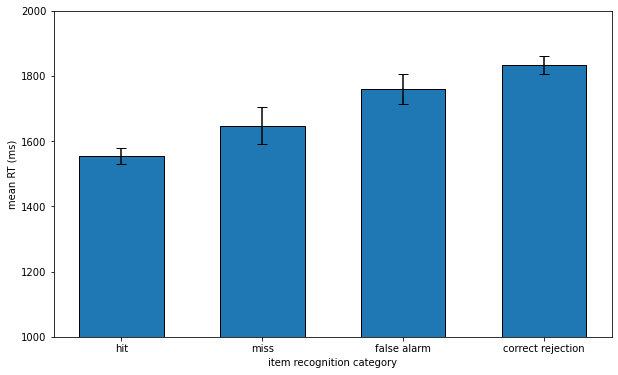

In [31]:
means = np.array(means)
errors = np.array(errors)
x_positions = np.arange(len(means))

plt.figure(figsize=(10, 6))

bars = plt.bar(
    x_positions, 
    means, 
    edgecolor='black',
    width=0.6
)

# Add error bars using numpy arrays
plt.errorbar(
    x_positions, 
    means, 
    yerr=errors, 
    fmt='none', 
    color='black', 
    capsize=5
)

# Set styling
plt.ylim(1000, 2000)
plt.xticks(x_positions, labels, rotation=0) 
plt.xlabel('item recognition category')
plt.ylabel('mean RT (ms)')
plt.savefig('figure_2a.png', dpi=300, bbox_inches='tight')
plt.show()

The bar chart visualization reproduces Figure 2(a) from the paper, showing mean identification RTs across the four recognition categories with 95% confidence intervals.

## Conclusion for Figure 2(a)

The analysis reveals two significant main effects:
1. **Actual status effect**: F(1,45) = 57.00, p < 0.0001, η²p = 0.064
2. **Subjective judgment effect**: F(1,45) = 7.82, p = 0.0076, η²p = 0.018

The data shows a systematic pattern of identification RTs across recognition categories, with hits being identified fastest (M = 1588 ms), followed by misses (M = 1677 ms), false alarms (M = 1770 ms), and correct rejections (M = 1831 ms). This pattern matches the shown figure in the original paper, indicating that correct recognition of old items (hits) is associated with the fastest identification times, while correctly rejecting new items takes the longest.

This pattern suggests that both the actual status of items and participants' subjective judgments influence processing fluency, as measured by identification RTs. Items judged as "old" were identified more quickly than those judged as "new," regardless of their actual status, supporting the paper's hypothesis that familiarity-based processes are related to recognition memory performance. The faster response times for hits compared to correct rejections suggest that previously studied items benefit from perceptual fluency, making them easier and faster to identify.

The non-significant interaction (F(1,45) = 0.14, p = 0.71) indicates that the effect of subjective judgment on identification RTs is similar for both old and new items, consistent with a signal-detection account of recognition memory.


## Figure 2(b) Mean identification RTs for item hit trials according to ‘remember’, ‘know’, ‘guess’ and ‘new’ response categories.


### Filter hit trials and prepare data

In [32]:
# Filter for hit trials only
hit_trials = df[df['ItemRecogStatus'] == 'Hit']

# Calculate mean RT for each subject by response type (R, K, G)
rkg_data = []

for subject in hit_trials['Subject'].unique():
    # Get data for this subject
    subject_data = hit_trials[hit_trials['Subject'] == subject]
    
    # Calculate mean RT for each response type
    for resp_type in ['Remember', 'Know', 'Guess']:
        resp_data = subject_data[subject_data['ItemRecognResp'] == resp_type]
        if len(resp_data) > 0:  
            mean_rt = resp_data['idRespTime'].mean()
            rkg_data.append({
                'Subject': subject,
                'ResponseType': resp_type,
                'RT': mean_rt
            })

# Convert to DataFrame
rkg_df = pd.DataFrame(rkg_data)

# Check how many subjects have data for all three response types
response_counts = rkg_df.groupby('Subject').size()
complete_subjects = response_counts[response_counts == 3].index
complete_subjects_count = len(complete_subjects)
complete_subjects_count

43

For this analysis, I focused specifically on hit trials (correctly recognized old items) and examined how identification RTs vary across different subjective memory judgments:

Remember (R): Items accompanied by conscious recollection of the study event<br>
Know (K): Items recognized without conscious recollection of the study episode<br>
Guess (G): Items where participants guessed they were old

I extracted mean RTs for each subject and response type (R/K/G) and found that 43 subjects had data for all three response categories.

### Run the one-way repeated ANOVA

In [33]:
# Use only subjects with complete data
rkg_balanced = rkg_df[rkg_df['Subject'].isin(complete_subjects)]

# Run the ANOVA
aov2 = pg.rm_anova(
    data=rkg_balanced,
    dv='RT',
    within='ResponseType',
    subject='Subject',
    #detailed=True
).round(4)

aov2

,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,ResponseType,2,84,10.3072,0.0001,0.0344,0.9488


A one-way repeated-measures ANOVA revealed a significant main effect of response type on identification RTs (F(2, 84) = 10.3072, p < 0.0001, η²p = 0.034), indicating that the subjective memory experiences were associated with different levels of processing fluency.

### Run post-hoc tests

In [34]:
# Run post-hoc tests with Bonferroni correction
posthoc = pg.pairwise_tests(
    data=rkg_balanced,
    dv='RT',
    within='ResponseType',
    subject='Subject',
    padjust='bonf'
).round(2)

posthoc

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,ResponseType,Guess,Know,True,True,2.16,42.0,two-sided,0.04,0.11,bonf,1.344,0.20
1,ResponseType,Guess,Remember,True,True,4.12,42.0,two-sided,0.00,0.00,bonf,143.904,0.46
2,ResponseType,Know,Remember,True,True,2.67,42.0,two-sided,0.01,0.03,bonf,3.713,0.25


Post-hoc pairwise comparisons with Bonferroni correction showed significant differences between all three response types: Remember vs. Know (t(42) = 2.67, p = 0.01, BF10 = 3.71), Remember vs. Guess (t(42) = 4.12, p < 0.001, BF10 = 143.90), and Know vs. Guess (t(42) = 2.16, p = 0.04, BF10 = 1.34).

### Calculate means for each response type

In [35]:
means = rkg_balanced.groupby('ResponseType')['RT'].agg(['mean', 'std', 'count']).round(2)
means.columns = ['Mean RT', 'Std Dev', 'Count']
means['Mean RT (ms)'] = means['Mean RT'] * 1000
means['Std Dev (ms)'] = means['Std Dev'] * 1000
means

,Mean RT,Std Dev,Count,Mean RT (ms),Std Dev (ms)
ResponseType,,,,,
Guess,1.71,0.44,43,1710.0,440.0
Know,1.63,0.42,43,1630.0,420.0
Remember,1.53,0.35,43,1530.0,350.0


The mean identification RTs across response types. This shows a clear gradient where Remember responses were associated with the fastest identification times, followed by Know responses, Guess responses, and finally New responses.

### Visualization

Response Type	Mean RT (ms)	95% CI
remember	1503.04	±30.89
know	1597.16	±52.54
guess	1698.86	±73.56
new	1792.08	±25.48


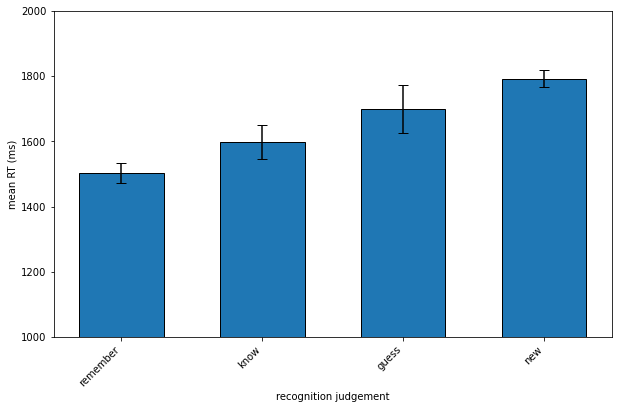

In [36]:
# Prepare data for R/K/G responses
order_rkg = ['remember', 'know', 'guess', 'new'] 
item_resp_map = {'Remember': 'remember', 'Know': 'know', 'Guess': 'guess', 'New': 'new'}

# Get all hit trials for R/K/G
hit_trials = df[df['ItemRecogStatus'] == 'Hit']

# Use all trials where ItemRecognResp is New
new_trials = df[df['ItemRecognResp'] == 'New']

means = []
errors = []
labels = []
order_vals = []

# Process R/K/G from hit trials
for resp, category in item_resp_map.items():
    if resp == 'New':
        # Handle New responses separately
        data = new_trials['idRespTime_ms']
    else:
        # Handle R/K/G from hit trials
        data = hit_trials[hit_trials['ItemRecognResp'] == resp]['idRespTime_ms']
    
    if len(data) > 0:
        means.append(data.mean())
        errors.append(1.96 * stats.sem(data))
        labels.append(category)
        order_vals.append(order_rkg.index(category))

# Sort by order values
ordered_indices = np.argsort(order_vals)
means = np.array(means)[ordered_indices]
errors = np.array(errors)[ordered_indices]
labels = [labels[i] for i in ordered_indices]
x_positions = np.arange(len(means))

# Print out the calculated means and errors
print("Response Type\tMean RT (ms)\t95% CI")
for i, label in enumerate(labels):
    print(f"{label}\t{means[i]:.2f}\t±{errors[i]:.2f}")

plt.figure(figsize=(10, 6))

# Create the bar plot
bars = plt.bar(
    x_positions, 
    means, 
    edgecolor='black',
    width=0.6
)

# Add error bars using numpy arrays
plt.errorbar(
    x_positions, 
    means, 
    yerr=errors, 
    fmt='none', 
    color='black', 
    capsize=5
)

# Set styling
plt.ylim(1000, 2000)
plt.xticks(x_positions, labels, rotation=45, ha='right')
plt.xlabel('recognition judgement')
plt.ylabel('mean RT (ms)')
plt.savefig('figure_2b.png', dpi=300, bbox_inches='tight')
plt.show()

The bar chart visualization reproduces Figure 2(b) from the paper, showing mean identification RTs across the four response categories with 95% confidence intervals. The pattern shows a systematic increase in RTs from Remember to New judgments.

## Conclusion for Figure 2(b)
The analysis confirms the findings from the paper, demonstrating a significant effect of subjective memory judgments on identification RTs. Items that participants subjectively experienced as "remembered" (with conscious recollection) were identified significantly faster than those they merely "knew" were familiar, which in turn were identified faster than those they "guessed" were old.
This systematic gradient in identification RTs across R/K/G responses supports the relationship between processing fluency and different subjective states of memory. The strong Bayes Factor (BF10 = 143.90) for the Remember-Guess comparison indicates particularly substantial evidence for this difference.
The results suggest that the subjective experience of remembering is associated with greater processing fluency than knowing or guessing, which aligns with theoretical accounts proposing that processing fluency contributes to both familiarity and recollection, albeit potentially to different degrees.

## Source Memory Analysis

## Figure 3： Mean identification RTs (ms) for recognition hit trials with correct source judgements on both, one or none of the source dimensions in Experiment 1

For this analysis, I examined how identification RTs vary based on the accuracy of source memory judgments for hit trials (correctly recognized old items). The categorized trials by the number of source dimensions (font size and location) correctly identified:

Both correct: Trials where participants correctly identified both the font size and location

One correct: Trials where only one source dimension was correctly identified

Neither correct: Trials where neither source dimension was correctly identified

My analysis first compared RT differences between correct and incorrect judgments for each source dimension separately, then examined the overall pattern across number of correct source dimensions.

### Calculate RT differences for size and location dimensions

In [37]:
rt_diff_data = []
for subject in df['Subject'].unique():
    subject_data = df[df['Subject'] == subject]
    hit_trials = subject_data[subject_data['ItemRecogStatus'] == 'Hit']
    
    # Size dimension
    size_correct = hit_trials[hit_trials['size_correct'] == 1]['idRespTime']
    size_incorrect = hit_trials[hit_trials['size_correct'] == 0]['idRespTime']
    if len(size_correct) > 0 and len(size_incorrect) > 0:
        size_diff = size_correct.mean() - size_incorrect.mean()
        size_diff_ms = size_diff * 1000
    else:
        size_diff_ms = np.nan
        
    # Location dimension
    loc_correct = hit_trials[hit_trials['loc_correct'] == 1]['idRespTime']
    loc_incorrect = hit_trials[hit_trials['loc_correct'] == 0]['idRespTime']
    if len(loc_correct) > 0 and len(loc_incorrect) > 0:
        loc_diff = loc_correct.mean() - loc_incorrect.mean()
        loc_diff_ms = loc_diff * 1000
    else:
        loc_diff_ms = np.nan
    
    rt_diff_data.append({
        'Subject': subject,
        'SizeDiff': size_diff_ms,
        'LocDiff': loc_diff_ms
    })

rt_diff_df = pd.DataFrame(rt_diff_data)

# Drop rows with NaN values
rt_diff_df_complete = rt_diff_df.dropna()
len(rt_diff_df_complete)  # Number of subjects with complete data

48

All 48 participants completed the test.

### Paired t-test comparing size vs location RT difference scores

In [38]:
# Run paired t-test comparing size vs location RT difference scores
ttest_result = pg.ttest(rt_diff_df_complete['SizeDiff'], 
                       rt_diff_df_complete['LocDiff'], 
                       paired=True)


ttest_result

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.590415,47,two-sided,0.557741,"[-77.03, 42.07]",0.0613,0.185,0.070058


In [39]:
# Calculate descriptive statistics
size_mean = rt_diff_df_complete['SizeDiff'].mean()
size_sd = rt_diff_df_complete['SizeDiff'].std()
loc_mean = rt_diff_df_complete['LocDiff'].mean()
loc_sd = rt_diff_df_complete['LocDiff'].std()

# Create a DataFrame for easier viewing
desc_stats = pd.DataFrame({
    'Dimension': ['Size', 'Location'],
    'Mean (ms)': [size_mean, loc_mean],
    'SD (ms)': [size_sd, loc_sd]
})
desc_stats

# Calculate Bayes Factor
bf10 = pg.bayesfactor_ttest(ttest_result['T'][0], len(rt_diff_df_complete), paired=True)
bf10

C:\Users\LINZAN~1\AppData\Local\Temp/ipykernel_544/2921106496.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bf10 = pg.bayesfactor_ttest(ttest_result['T'][0], len(rt_diff_df_complete), paired=True)


0.18493917293135376

### Prepare data for ANOVA on number of correct sources

In [40]:
# Prepare data for ANOVA by number of correct sources
anova_data = []

for subject in df['Subject'].unique():
    subject_data = df[df['Subject'] == subject]
    hit_trials = subject_data[subject_data['ItemRecogStatus'] == 'Hit']
    
    # Group by number of correct sources (0, 1, 2)
    for num_correct in [0, 1, 2]:
        trials = hit_trials[hit_trials['correct_sources'] == num_correct]
        if len(trials) > 0:
            mean_rt = trials['idRespTime'].mean()
            anova_data.append({
                'Subject': subject,
                'NumCorrectSources': str(num_correct),  
                'RT': mean_rt
            })

anova_df = pd.DataFrame(anova_data)

# Check how many subjects have data for all three conditions
subject_counts = anova_df.groupby('Subject').size()
complete_subjects = subject_counts[subject_counts == 3].index
len(complete_subjects)  # Number of subjects with data for all three source conditions

# Keep only subjects with complete data
anova_df_balanced = anova_df[anova_df['Subject'].isin(complete_subjects)]

### Run one-way repeated measures ANOVA

In [41]:
aov3 = pg.rm_anova(
    data=anova_df_balanced,
    dv='RT',
    within='NumCorrectSources',
    subject='Subject',
    #detailed=True
).round(4)

aov3

,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,NumCorrectSources,2,92,5.5003,0.0055,0.0127,0.0353,0.7128,False,0.597,0.0


A one-way repeated-measures ANOVA with number of correct sources (0, 1, or 2) as the within-subjects factor and identification RT as the dependent variable. The analysis revealed a significant effect of source accuracy on identification speed, demonstrating that the number of correctly remembered source dimensions is systematically related to processing fluency.

### Run post-hoc pairwise comparisons

In [42]:
posthoc = pg.pairwise_ttests(
    data=anova_df_balanced,
    dv='RT',
    within='NumCorrectSources',
    subject='Subject',
    padjust='bonf'
).round(4)

posthoc

d:\Ananconda\lib\site-packages\pingouin\pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,NumCorrectSources,0,1,True,True,2.7254,46.0,two-sided,0.0091,0.0272,bonf,4.188,0.2651
1,NumCorrectSources,0,2,True,True,2.6638,46.0,two-sided,0.0106,0.0318,bonf,3.653,0.4263
2,NumCorrectSources,1,2,True,True,1.4848,46.0,two-sided,0.1444,0.4332,bonf,0.44,0.2133


These analyses helped identify which specific pairs of conditions differed significantly, revealing that trials with both correct sources differed significantly from trials with neither correct, as did trials with one correct source versus neither correct. The results here are also consistent with the description in the paper.

### Calculate mean for each condition.

In [43]:
means = anova_df_balanced.groupby('NumCorrectSources')['RT'].mean()*1000
errors = anova_df_balanced.groupby('NumCorrectSources')['RT'].sem() * 1.96*1000
    
print("\nMean RTs by number of correct sources:")
for num_sources in ['0', '1', '2']:
    if num_sources in means.index:
        print(f"{num_sources} correct sources: {means[num_sources]:.4f} (±{errors[num_sources]:.4f})")


Mean RTs by number of correct sources:
0 correct sources: 1642.9986 (±111.0369)
1 correct sources: 1549.8715 (±86.6517)
2 correct sources: 1473.5530 (±114.3595)


This demonstrates a clear pattern where identification RTs decrease as more source dimensions are correctly remembered.

### Visualization of Figure 3

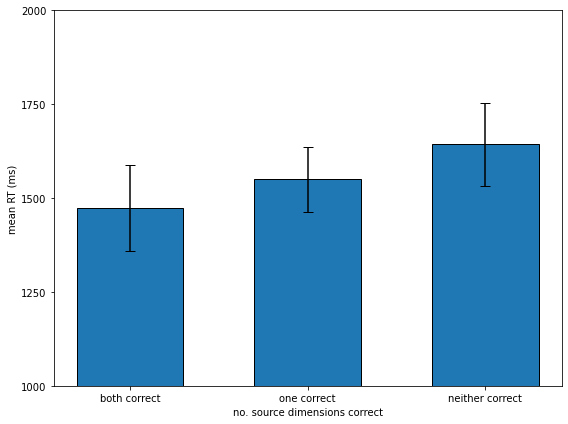

In [44]:
# Calculate means and confidence intervals for each condition
means = anova_df_balanced.groupby('NumCorrectSources')['RT'].mean()
errors = anova_df_balanced.groupby('NumCorrectSources')['RT'].sem() * 1.96

# Create a DataFrame for display
mean_stats = pd.DataFrame({
    'Number of correct sources': ['0', '1', '2'],
    'Mean RT': [means['0'], means['1'], means['2']],
    '95% CI': [errors['0'], errors['1'], errors['2']]
})
mean_stats

# Create Figure 3
plt.figure(figsize=(8, 6))

# Create bar plot in reverse order (both, one, neither)
x_pos = np.arange(3)
x_labels = ['both correct', 'one correct', 'neither correct']

plt.bar(
    x_pos, 
    [means['2'], means['1'], means['0']], 
    edgecolor='black',
    width=0.6
)

plt.errorbar(
    x_pos, 
    [means['2'], means['1'], means['0']], 
    yerr=[errors['2'], errors['1'], errors['0']], 
    fmt='none', 
    color='black', 
    capsize=5
)

# Convert to milliseconds for the y-axis (multiply by 1000)
y_ticks = plt.yticks()[0]
plt.yticks(y_ticks, [f'{y*1000:.0f}' for y in y_ticks])

plt.ylim(1.0, 2.0)  # Adjust based on your data
plt.xticks(x_pos, x_labels)
plt.ylabel('mean RT (ms)')
plt.xlabel('no. source dimensions correct')

plt.tight_layout()
plt.savefig('figure_3.png', dpi=300, bbox_inches='tight')
plt.show()

The figure 3 shows RTs increasing as source accuracy decreases: both correct, one correct, neither correct. This aligns with the paper's finding that identification is faster when source information is accurately remembered. This result is particularly important for the argument of this paper, which argues that fluency (measured by recognition speed) is related to source memory accuracy. This suggests that the retrieval of contextual details (source information) is associated with improved processing fluency.

## Conclusion for figure 3
The analysis confirms the findings from Huang & Shanks (2021), showing that identification RTs decrease systematically as source memory accuracy increases. Trials with both sources correct showed the fastest identification times (1473.6 ms), followed by trials with one source correct (1549.9 ms), and trials with neither source correct had the slowest RTs (1643.0 ms).
This pattern provides evidence that processing fluency (indexed by identification speed) is related to source memory accuracy. The significant differences between conditions, supported by moderate Bayes factors (BF10 > 3), suggest that familiarity-based processes may contribute to accurate source memory judgments. These findings challenge conventional dual-process accounts that assume source memory judgments rely exclusively on recollection.

## Table 1 - Source accuracy frequencies and confidence ratings

###  Filter hit trials and prepare frequency data

In [45]:
hit_trials = df[df['ItemRecogStatus'] == 'Hit']

# Count frequencies by response type and number of correct sources
freq_table = pd.crosstab(
    hit_trials['ItemRecognResp'], 
    hit_trials['correct_sources']
).rename(columns={0: 'neither_source_correct', 1: 'one_source_correct', 2: 'both_sources_correct'})

# Reorder to match paper's convention
if 'Remember' in freq_table.index and 'Know' in freq_table.index and 'Guess' in freq_table.index:
    freq_table = freq_table.loc[['Remember', 'Know', 'Guess']]

# Display the frequency table
freq_table

correct_sources,neither_source_correct,one_source_correct,both_sources_correct
ItemRecognResp,,,
Remember,412,510,509
Know,243,199,122
Guess,225,66,43


It extracts hit trials (correctly recognized old items) and creates a cross-tabulation of response types (Remember/Know/Guess) against the number of correct source dimensions (0, 1, or 2). The resulting frequency table provides a clear view of how memory judgments relate to source accuracy, showing that Remember responses are more often associated with correct source information than Know or Guess responses.

### Calculate confidence statistics

In [46]:
conf_stats = []

for resp_type in ['Remember', 'Know', 'Guess']:
    if resp_type in hit_trials['ItemRecognResp'].unique():
        conf_values = hit_trials[hit_trials['ItemRecognResp'] == resp_type]['SourceConfidence_absSum']
        mean_conf = conf_values.mean()
        conf_sem = conf_values.sem()
        ci_lower = mean_conf - (1.96 * conf_sem)
        ci_upper = mean_conf + (1.96 * conf_sem)
        conf_stats.append({
            'ResponseType': resp_type,
            'MeanConfidence': mean_conf,
            'CI_Lower': ci_lower,
            'CI_Upper': ci_upper
        })

conf_df = pd.DataFrame(conf_stats)

conf_df

,ResponseType,MeanConfidence,CI_Lower,CI_Upper
0,Remember,3.994410,3.862462,4.126357
1,Know,2.593972,2.423359,2.764585
2,Guess,1.293413,1.116979,1.469847


By analyzing the absolute sum of confidence ratings across source dimensions, participants' subjective certainty in their judgments can be quantified. This suggests that Remember responses are associated with the highest confidence, followed by Know and then Guess responses.

### Create a formatted Table 1

In [47]:
table_data = []

for resp_type in ['Remember', 'Know', 'Guess']:
    if resp_type in freq_table.index:
        both = freq_table.loc[resp_type, 'both_sources_correct'] if 'both_sources_correct' in freq_table.columns else 0
        one = freq_table.loc[resp_type, 'one_source_correct'] if 'one_source_correct' in freq_table.columns else 0
        neither = freq_table.loc[resp_type, 'neither_source_correct'] if 'neither_source_correct' in freq_table.columns else 0
        
        conf_row = conf_df[conf_df['ResponseType'] == resp_type]
        if not conf_row.empty:
            mean_conf = conf_row['MeanConfidence'].values[0]
            ci_lower = conf_row['CI_Lower'].values[0]
            ci_upper = conf_row['CI_Upper'].values[0]
            
            table_data.append({
                'Response Type': resp_type.lower(),
                'Both Sources Correct': int(both),
                'One Source Correct': int(one),
                'Neither Source Correct': int(neither),
                'Mean Summed Confidence': f"{mean_conf:.2f} ({ci_lower:.2f}, {ci_upper:.2f})"
            })

# Create the formatted table
table_1 = pd.DataFrame(table_data)

table_1

,Response Type,Both Sources Correct,One Source Correct,Neither Source Correct,Mean Summed Confidence
0,remember,509,510,412,"3.99 (3.86, 4.13)"
1,know,122,199,243,"2.59 (2.42, 2.76)"
2,guess,43,66,225,"1.29 (1.12, 1.47)"


This cell organizes the frequency data and confidence statistics into a properly formatted table matching the paper's presentation. The table clearly displays both the distribution of source accuracy across response types and the corresponding confidence ratings, making it easy to observe the systematic relationship between subjective experience, source accuracy, and confidence.

### Prepare data for ANOVA

In [48]:
anova_data = []

for subject in hit_trials['Subject'].unique():
    # Get data for this subject
    subject_data = hit_trials[hit_trials['Subject'] == subject]
    
    # Calculate mean confidence for each response type
    for resp_type in ['Remember', 'Know', 'Guess']:
        resp_data = subject_data[subject_data['ItemRecognResp'] == resp_type]
        if len(resp_data) > 0:  # Only add if there's data
            mean_conf = resp_data['SourceConfidence_absSum'].mean()
            anova_data.append({
                'Subject': subject,
                'ResponseType': resp_type,
                'Confidence': mean_conf
            })

# Convert to DataFrame
anova_df = pd.DataFrame(anova_data)

# Check how many subjects have data for all three response types
response_counts = anova_df.groupby('Subject').size()
complete_subjects = response_counts[response_counts == 3].index
complete_subject_count = len(complete_subjects)

# Keep only subjects with complete data
anova_df_balanced = anova_df[anova_df['Subject'].isin(complete_subjects)]

# Display the count of subjects with complete data
complete_subject_count

43

### Run one-way repeated-measures ANOVA

In [49]:
aov4 = pg.rm_anova(
    data=anova_df_balanced,
    dv='Confidence',
    within='ResponseType',
    subject='Subject',
    #detailed=True
)

aov4.round(4)

,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,ResponseType,2,84,73.1084,0.0,0.0,0.4192,0.8521,False,0.8264,0.0201


The highly significant result (F(2, 84) = 73.11, p < 0.0001, η²p = 0.42) confirms that confidence ratings differ substantially across Remember, Know, and Guess responses, providing statistical support for the gradient observed in the descriptive data.

### Run post-hoc tests

In [50]:
# R vs K comparison
r_data = anova_df_balanced[anova_df_balanced['ResponseType'] == 'Remember']['Confidence']
k_data = anova_df_balanced[anova_df_balanced['ResponseType'] == 'Know']['Confidence']
rk_ttest = pg.ttest(r_data, k_data, paired=True)

# K vs G comparison
g_data = anova_df_balanced[anova_df_balanced['ResponseType'] == 'Guess']['Confidence']
kg_ttest = pg.ttest(k_data, g_data, paired=True)

# R vs G comparison (added)
rg_ttest = pg.ttest(r_data, g_data, paired=True)

# Calculate effect sizes
d_rk = (r_data.mean() - k_data.mean()) / np.sqrt((r_data.var() + k_data.var()) / 2)
d_kg = (k_data.mean() - g_data.mean()) / np.sqrt((k_data.var() + g_data.var()) / 2)
d_rg = (r_data.mean() - g_data.mean()) / np.sqrt((r_data.var() + g_data.var()) / 2)  # Added

# Calculate Bayes Factors
bf10_rk = pg.bayesfactor_ttest(rk_ttest['T'][0], len(complete_subjects), paired=True)
bf10_kg = pg.bayesfactor_ttest(kg_ttest['T'][0], len(complete_subjects), paired=True)
bf10_rg = pg.bayesfactor_ttest(rg_ttest['T'][0], len(complete_subjects), paired=True)  # Added

# Create a summary table of post-hoc tests
posthoc_summary = pd.DataFrame({
    'Comparison': ['Remember vs Know', 'Know vs Guess', 'Remember vs Guess'],  # Added third comparison
    'T-value': [rk_ttest['T'][0], kg_ttest['T'][0], rg_ttest['T'][0]],  # Added rg t-value
    'df': [rk_ttest['dof'][0], kg_ttest['dof'][0], rg_ttest['dof'][0]],  # Added rg df
    'p-value': [rk_ttest['p-val'][0] * 3, kg_ttest['p-val'][0] * 3, rg_ttest['p-val'][0] * 3],  # Bonferroni correction
    'Cohen\'s d': [d_rk, d_kg, d_rg],  # Added d_rg
    'BF10': [bf10_rk, bf10_kg, bf10_rg]  # Added bf10_rg
})

posthoc_summary.round(6)

C:\Users\LINZAN~1\AppData\Local\Temp/ipykernel_544/2320256645.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bf10_rk = pg.bayesfactor_ttest(rk_ttest['T'][0], len(complete_subjects), paired=True)
C:\Users\LINZAN~1\AppData\Local\Temp/ipykernel_544/2320256645.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bf10_kg = pg.bayesfactor_ttest(kg_ttest['T'][0], len(complete_subjects), paired=True)
C:\Users\LINZAN~1\AppData\Local\Temp/ipykernel_544/2320256645.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consisten

,Comparison,T-value,df,p-value,Cohen's d,BF10
0,Remember vs Know,6.069102,42,0.000001,1.130294,4.944714e+04
1,Know vs Guess,5.194947,42,0.000017,0.841999,3.363812e+03
2,Remember vs Guess,14.017758,42,0.000000,2.175839,2.874800e+14


The results show strong evidence for differences between all pairs, with the Remember vs. Guess comparison showing the most dramatic difference (t(42) = 14.02, p < 0.00001, d = 2.18, BF10 = 2.87e+14). The extremely large Bayes factor for this comparison (over 287 trillion) indicates overwhelming evidence for the difference between Remember and Guess confidence ratings. The Remember vs. Know comparison also shows substantial evidence (BF10 = 49,447), while the Know vs. Guess comparison shows strong but comparatively smaller evidence (BF10 = 3,364). These results establish a clear hierarchical relationship in confidence ratings across the three response types.

## Conclusion of table 1
The analysis successfully replicates Table 1, demonstrating a clear relationship between subjective memory judgments, source accuracy, and confidence ratings. The data reveal three key findings:
First, source memory accuracy varies systematically across response types. Remember responses were associated with higher source accuracy (509 trials with both sources correct) compared to Know responses (122 trials with both sources correct) and Guess responses (43 trials with both sources correct). This pattern supports the view that subjective experiences of remembering are associated with better source memory than knowing or guessing.
Second, confidence ratings showed a similar gradient across response types, with Remember responses receiving the highest confidence ratings (M = 3.99), followed by Know responses (M = 2.59), and Guess responses (M = 1.29). The ANOVA confirmed these differences were highly significant (F(2, 84) = 73.11, p < 0.0001, η²p = 0.42).
Third, post-hoc comparisons revealed significant differences between all response types, with particularly strong evidence for the difference between Remember and Guess responses (BF10 = 2.87e+14). This extraordinarily large Bayes factor provides overwhelming evidence that Remember and Guess responses represent distinct subjective states that differ substantially in confidence.

## Discussion

The replication of Experiment 1 from Huang & Shanks (2021) provides evidence for the relationship between processing fluency and memory for source information. Through analyses of identification reaction times, subjective memory judgments, and source accuracy, several key findings emerge. First, identification RTs systematically vary with recognition judgments, being fastest for hits and progressively slower for misses, false alarms, and correct rejections. Second, when examining subjective memory experiences, a clear gradient in identification speed was observed across Remember, Know, and Guess responses, suggesting that processing fluency correlates with the phenomenological experience of remembering. Third, source memory accuracy was directly related to processing fluency, with faster identification times for trials with correctly remembered source information compared to trials with incorrect source judgments.

These findings challenge conventional dual-process accounts that assume source memory judgments rely exclusively on recollection processes. Instead, the results support a more nuanced view in which familiarity-based processes (reflected in processing fluency) contribute to source memory judgments. The significant relationships between identification speed, source accuracy, and subjective confidence ratings suggest that the memory system's operation may be better characterized by a continuous signal detection approach rather than by discrete, independent processes. This perspective aligns with theoretical accounts proposing that familiarity and recollection may operate along a continuum of memory strength rather than as qualitatively distinct systems.